# Final Project
**DATA110: Intro to Machine Learning**  
Brian Roepke  
April 24th, 2021  

# INTRODUCTION

The concept of social ratings and reviews of products is a common model of recommendation that the internet-enabled. We use reviews in nearly all aspects of eCommerce.  Products on Amazon contain reviews and ratings that help us find the top-rated product.  Reviews on TripAdvisor help us find the best places to have a vacation.  For businesses and restaurants, a common destination is **Yelp**.  Headquartered in San Francisco, California, it develops, hosts, and markets the Yelp.com website and the Yelp mobile app, which publish crowd-sourced reviews about businesses. It also operates an online reservation service called Yelp Reservations [8].  As of June 30, 2019, Yelp stated they had 192 million reviews on their site [8].

How important are these reviews to businesses? Reviews become a critical way for us to find trusted information, and that translates to more business. According to a Professor at Harvard Business School, an analysis of Yelp reviews found that each star rating for a business translated to a 5-9% increase in revenues [1].

Yelp has opened up a large portion of its dataset for academic and personal use. It contains a massive amount of textual data from their reviews and other information about their businesses.  The following analysis uses a subset of that information to try to understand the following questions better:

1. Leveraging a **lexicon-based sentiment** polarity score, find the most positive and negative **words frequencies** across reviews and what insights this brings.
1. Utilizing a Machine Learning model for **classification** determines the relationship between the **text** of the review and its **rating**. Is there a relationship between what people write about a business to the star rating they give it? Can this be combined with any other data to improve this prediction?
1. Use a Machine Learning **Multi-label classification** model to see what **categories** would an algorithm recommended a business use and how they related to the ones that a business manually chose.
1. Build a **Neural Network** using [TensorFlow](https://www.tensorflow.org) with **text** as input layer and the review rating as output if we can improve on the statistical Machine Learning model above.

![Yelp](https://raw.githubusercontent.com/broepke/DATA110/main/Final%20Project/yelp.png)

# EDA/DATA PREP

In [1]:
import numpy as np
import pandas as pd
import re
import itertools
import string
import warnings
from timeit import timeit
warnings.filterwarnings('ignore')

from textblob import TextBlob
from textblob import Word

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2

# NLTK Imports and Downloads
import nltk
from nltk import word_tokenize
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('yelp.csv')

## Data Prep

In [3]:
df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",bkHUOCicGZ856vpvcWuW7Q,93z0yh-sUpGZS-cSKu6xxA,5.0,1,0,0,Stopped in on a busy Friday night. Despite the...,2018-03-04 00:59:21
1,1,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",VKBc48PPwyWIUE1RhBT_8A,Q_CZIvnsDHjpls-EPzzG7Q,2.0,0,0,0,Went there about 1 PM on a Monday. It wasn't ...,2018-08-14 05:22:00
2,2,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",JKNv1l7JgayZjG6nK__hXQ,rqxTSFFj5fZNmabY1fmTlw,5.0,0,0,0,This was the place the be on Friday Night! If ...,2018-03-17 14:22:48
3,3,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",WNM_Oyzy6mB6n0Z9lcuZyQ,vNPxlt5f50q0e2nVAScW3Q,4.0,0,0,0,Went to this place with my family over the wee...,2018-04-04 21:16:50
4,4,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,"Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",jG4gZz5FrHyItJXz1YV9Sw,eXRC79iX60xwA1UuGRuWNg,4.0,0,0,0,"Stopped on a midweek afternoon, and so glad th...",2018-04-28 19:17:04


In [4]:
df.tail()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
99995,99995,xcpDb3OWQ60W4zOV2ns90Q,Choco Coo,"501 North Road, Suite C",Coquitlam,BC,V3J,49.249401,-122.892146,3.5,...,"Food, Coffee & Tea, Cafes, Restaurants, French...","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'...",5_aGKbf-7d0NbnaFbO98aw,OFAZ7h1lT-aq9am4Gz10YQ,2.0,0,0,0,Was excited to try this cafe after seeing the ...,2017-07-20 06:03:50
99996,99996,xcpDb3OWQ60W4zOV2ns90Q,Choco Coo,"501 North Road, Suite C",Coquitlam,BC,V3J,49.249401,-122.892146,3.5,...,"Food, Coffee & Tea, Cafes, Restaurants, French...","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'...",e8QsByN-Ky5DYRC6bo9Uig,lO_FaZrocR0x3dgoFk38zw,4.0,1,0,0,I love this cute little place. My favourite pa...,2017-08-10 17:36:43
99997,99997,xcpDb3OWQ60W4zOV2ns90Q,Choco Coo,"501 North Road, Suite C",Coquitlam,BC,V3J,49.249401,-122.892146,3.5,...,"Food, Coffee & Tea, Cafes, Restaurants, French...","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'...",GI8M2qhjuzVOfN8U5naNyg,eg2f_A2tezVrbRf64UAoaA,1.0,1,0,0,This place was terrible. I got my friend the s...,2018-05-29 22:30:37
99998,99998,xcpDb3OWQ60W4zOV2ns90Q,Choco Coo,"501 North Road, Suite C",Coquitlam,BC,V3J,49.249401,-122.892146,3.5,...,"Food, Coffee & Tea, Cafes, Restaurants, French...","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'...",3P0Mgv0vKOM58tffbjM9wg,qSyKN1UV6mbRxPn4YlX6cg,4.0,0,0,0,"cute, minimalist space. the barista seemed new...",2017-12-31 22:58:16
99999,99999,xcpDb3OWQ60W4zOV2ns90Q,Choco Coo,"501 North Road, Suite C",Coquitlam,BC,V3J,49.249401,-122.892146,3.5,...,"Food, Coffee & Tea, Cafes, Restaurants, French...","{'Monday': '12:0-23:0', 'Tuesday': '12:0-23:0'...",x57hcMog0G-ek9yD4gUcow,d9LPTSLuFU0Mus3b9doJEQ,4.0,0,0,0,Found this place on Yelp and it was close by s...,2018-03-18 06:54:10


In [5]:
df.shape

(100000, 23)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [6]:
# Drop NULL values
df.dropna(inplace=True)

In [7]:
# Drop unwanted columns
df.drop(columns=['Unnamed: 0', 'longitude', 'latitude'], inplace=True)

In [8]:
df['date'] =  pd.to_datetime(df['date'])

In [9]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['text']), axis = 1)

In [10]:
# add a column for positive or negative
df['target'] = df['stars_y'].apply(lambda c: 0 if c < 4 else 1)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [11]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 90652
After = 90652

Total Removed = 0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90652 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   business_id   90652 non-null  object        
 1   name          90652 non-null  object        
 2   address       90652 non-null  object        
 3   city          90652 non-null  object        
 4   state         90652 non-null  object        
 5   postal_code   90652 non-null  object        
 6   stars_x       90652 non-null  float64       
 7   review_count  90652 non-null  int64         
 8   is_open       90652 non-null  int64         
 9   attributes    90652 non-null  object        
 10  categories    90652 non-null  object        
 11  hours         90652 non-null  object        
 12  review_id     90652 non-null  object        
 13  user_id       90652 non-null  object        
 14  stars_y       90652 non-null  float64       
 15  useful        90652 non-null  int64 

In [13]:
# show counts values of each categorical variable
print (df['city'].value_counts(), '\n')
print (df['state'].value_counts(), '\n')

Austin                15652
Portland              11691
Boston                 9222
Atlanta                8913
Vancouver              6763
                      ...  
Lithopolis                1
Needham Heights           1
Middleton                 1
Newton Upper Falls        1
Oak Grove                 1
Name: city, Length: 274, dtype: int64 

MA    24117
TX    16203
OR    14174
FL    11246
GA    11221
BC     7280
OH     3748
CO     1387
WA     1273
KS        3
Name: state, dtype: int64 



In [14]:
print(len(df))
df = df[df['state'] != 'KS'].copy()
print(len(df))

90652
90649


**Note:** There are not enough observations for Kansas, these have been dropped.

**Variable Descriptions:**  

1. **business_id:** string, 22 character unique string business id
1. **name:** string, the business's name
1. **address:** string, the full address of the business
1. **city:** string, the city
1. **state:** string, 2 character state code, if applicable
1. **postal code:** string, the postal code
1. **latitude:** float, latitude
1. **longitude:** float, longitude
1. **stars_x:** float, star rating, rounded to half-stars
1. **review_count:** integer, number of reviews
1. **is_open:** integer, 0 or 1 for closed or open, respectively
1. **attributes:** object, business attributes to values. note: some attribute values might be objects
1. **categories:** an array of strings of business categories
1. **hours:** an object of key day to value hours, hours are using a 24hr clock
1. **review_id:** string, 22 character unique string review id
1. **stars_y:** integer, star rating (the data is a float64 here, but only valid numbers were integers 1-5)
1. **useful:** integer, number of useful votes received
1. **funny:** integer, number of funny votes received
1. **cool:** integer, number of cool votes received

## EDA

In [15]:
df.describe()

,stars_x,review_count,is_open,stars_y,useful,funny,cool,text_len,target
count,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000,90649.000000
mean,3.749611,424.967578,0.789319,3.802215,0.958190,0.326953,0.368454,576.716235,0.683802
std,0.639393,669.496044,0.407794,1.356062,2.103044,1.188864,1.193615,526.057956,0.464994
min,1.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000
25%,3.500000,79.000000,1.000000,3.000000,0.000000,0.000000,0.000000,236.000000,0.000000
50%,4.000000,214.000000,1.000000,4.000000,0.000000,0.000000,0.000000,416.000000,1.000000
75%,4.000000,477.000000,1.000000,5.000000,1.000000,0.000000,0.000000,733.000000,1.000000
max,5.000000,4708.000000,1.000000,5.000000,128.000000,39.000000,47.000000,5000.000000,1.000000


**Observations:**
1. There are over `90k` observations in the dataset.
1. Overall star ratings for places tend to be on the positive side.  A mean of `3.5` and the `50%` and `75%` values are `4.0`.
1. For individual reviews, there is a similar pattern—about the same mean value at `3.8` (slightly higher).
1. The longest review in the list is `5000` characters.  Probably the limit of characters.

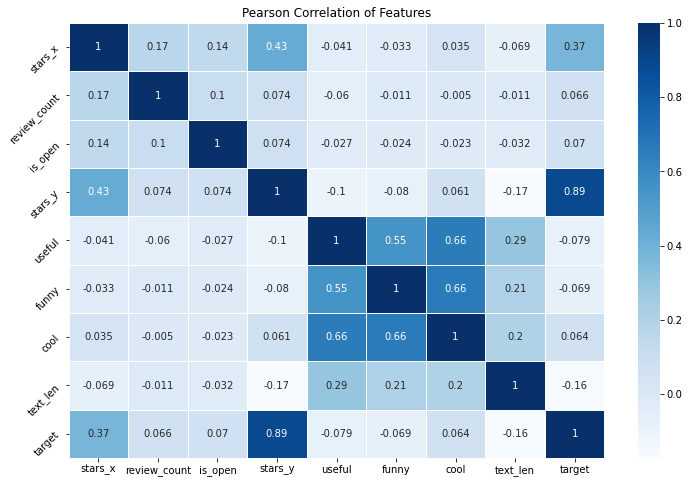

In [16]:
corr = df.corr()

f, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.yticks(rotation=45);

**Observations:**  
There are a few variables that are correlated to each other.  
 - `target` was created from `stars_y` and therefore shows a high positive correlation
 - `cool`, `useful` and `funny` are slightly correlated to each other.  This probably means that users to vote with one item, vote with others. 
 - `stars_y` and `stars_x`also show some correlation.  This makes sense because `stars_x` is the mean of all `stars_y` ratings.

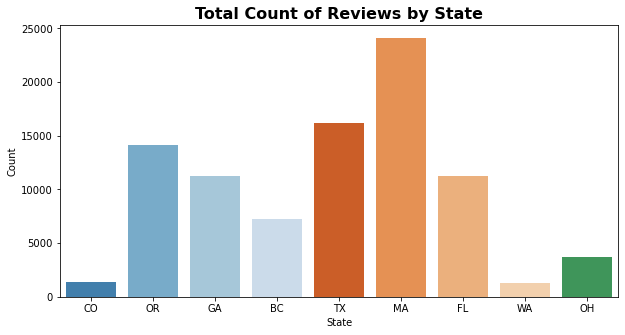

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='state', palette='tab20c')
plt.title("Total Count of Reviews by State", weight='bold').set_fontsize('16')
plt.xlabel("State")
plt.ylabel("Count");

**Observations:**
1. `TX`, `MA`, `OR`, and `FL` have the most reviews in the dataset.
1. There are relativley small number for `CO` and `WA`. 

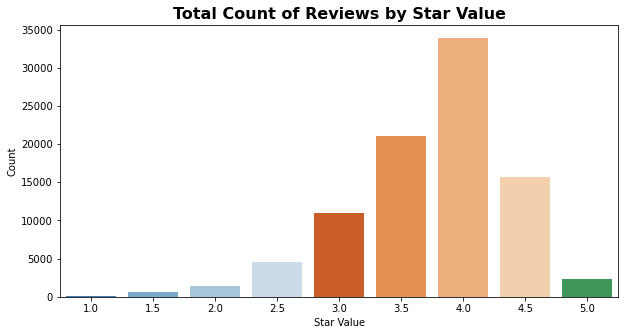

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="stars_x", palette='tab20c')
plt.title("Total Count of Reviews by Star Value", weight='bold').set_fontsize('16')
plt.xlabel("Star Value")
plt.ylabel("Count");

**Observations:**


 When looking at the star distributions for each *business average* (count by value), we can see that they tend to be biassed towards the `4.0` values as we saw above.
 Interestingly, there are not many `5.0` star reviews; most people tend to rate `3.5` to `4.5`.

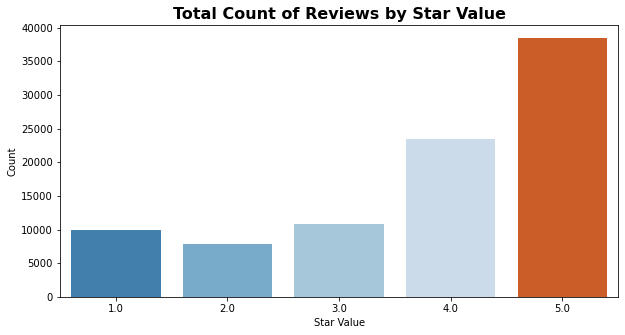

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="stars_y", palette='tab20c')
plt.title("Total Count of Reviews by Star Value", weight='bold').set_fontsize('16')
plt.xlabel("Star Value")
plt.ylabel("Count");

**Observations:**
 - When looking at the star distributions for each *review*, we see a slightly different pattern—a much larger proportion of `5.0` reviews. 
 - There is a much more pronounced quantity of `1.0` star reviews as well.

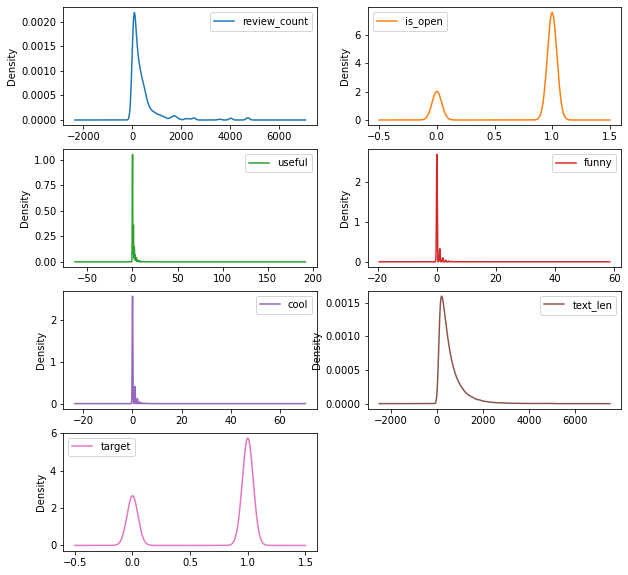

In [20]:
numeric_data = df.select_dtypes(include=['int64'])
numeric_data.plot(figsize=(10,10), kind='density',subplots=True, layout=(4,2), sharex=False);

**Observations:**
 - Given the nature of the remaining values (mostly binary, review counts, or counters for the "likes"), these distributions do not tell us too much.

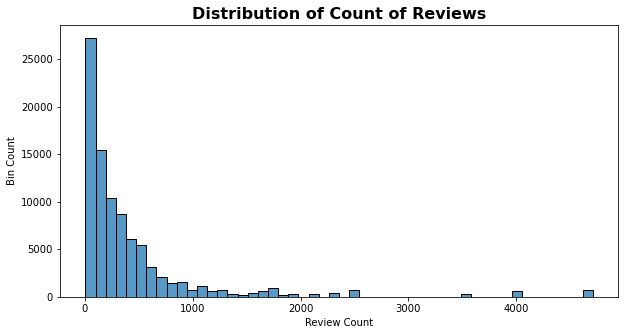

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(x='review_count', data=df, bins=50);
plt.title("Distribution of Count of Reviews", weight='bold').set_fontsize('16')
plt.xlabel("Review Count")
plt.ylabel("Bin Count");

**Observations:**
 - Regarding the number of reviews per business, most businesses tend to have a lower count of reviews, in the `10's` or `100's`.   
 - The max number is well above `4,000`.

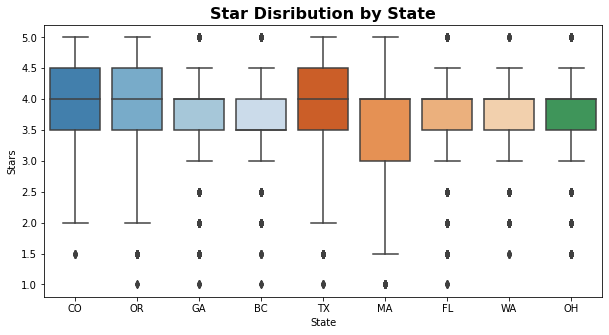

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='state', y='stars_x', palette="tab20c")
plt.title("Star Disribution by State", weight='bold').set_fontsize('16')
plt.xlabel("State")
plt.ylabel("Stars");


**Notes**
- The mean of all states appears to be exactly 4.0 stars.  While there are outliers in each, there is a very uniform distribution between states in the dataset. 
- `CO`, `OR`, and `TX` has a slightly larger variance around the median.
- The rest of the states have their interquartile range falling below `4.0` stars.

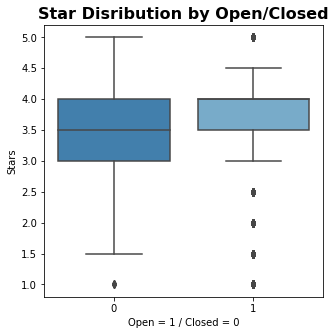

In [23]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='is_open', y='stars_x', palette="tab20c")
plt.title("Star Disribution by Open/Closed", weight='bold').set_fontsize('16')
plt.xlabel("Open = 1 / Closed = 0")
plt.ylabel("Stars");

**Notes:**
- Between open and closed reviews, there is a slightly smaller interquartile range around the mean for open stores.
- There also is a larger range for the upper and lower quartiles.

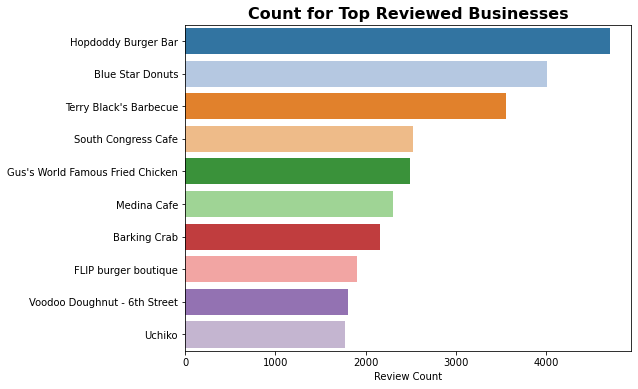

In [24]:
df_most_reviews = df.groupby('name').mean().sort_values('review_count', ascending=False)[0:10]
df_most_reviews.reset_index(inplace=True)
plt.figure(figsize=(8,6))
sns.barplot(y='name', x='review_count' , data=df_most_reviews, palette="tab20")
plt.title("Count for Top Reviewed Businesses", weight='bold').set_fontsize('16')
plt.xlabel("Review Count")
plt.ylabel("");

**Observations:**
 - A quick view of the top related restaraunts.  Burgers, BBQ, Dougnuts.  All of them appear to be `food` related businesses.

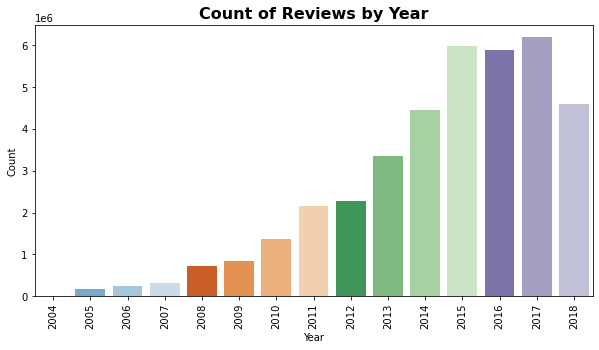

In [25]:
df_year = df.groupby(pd.Grouper(key='date',freq='Y')).sum()
df_year.reset_index(inplace=True)
plt.figure(figsize=(10,5))
g = sns.barplot(data=df_year, x='date', y='review_count', palette='tab20c')
g.set_xticks(range(len(df_year)))
g.set_xticklabels(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012','2013','2014','2015','2016','2017','2018'], 
                  rotation=90)
plt.title("Count of Reviews by Year", weight='bold').set_fontsize('16')
plt.xlabel("Year")
plt.ylabel("Count");

**Observations:**
- The number of reviews spans from `2004` to `2018` and increases through the `15-16-17` years with slightly less in `2018`.

### Check for Outliers

In [26]:
# Function to print the number of outliers in a column.
def get_outliers(df):
    '''Function to identify the number of outliers +/- 3 standard deviations outside of mean.
    Pass this function a dataframe and it returns a dictionary'''
    
    outs = {}
    
    df = df.select_dtypes(include=['int64'])

    
    for col in df.columns:
        
        # calculate summary statistics
        data_mean, data_std = np.mean(df[col]), np.std(df[col])
        
        # identify outliers
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off
        
        # identify outliers
        outliers = [x for x in df[col] if x < lower or x > upper]
        
        outs[col] = len(outliers)
        
    return outs

In [27]:
get_outliers(df)

{'review_count': 2195,
 'is_open': 0,
 'useful': 1389,
 'funny': 1615,
 'cool': 1643,
 'text_len': 1781,
 'target': 0}

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work properly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of the text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to their *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `swimming` and `swimmer` will be reduced to `swim`.

**Note**: The original text will be preserved for other analysis.

In [28]:
df['text'][0]

"Stopped in on a busy Friday night. Despite the crowd, the service was expedient and warm. \n\nThe beers here speak for themselves, so we sampled some of their taproom only offerings, and the galaxy smash was clean, tropical and sessionable.\n\nThis being said, the real star of this place is the pizza. It's a hand tossed style crust, that's the perfect mix of crispy and doughy. We ordered the special pizza (luau- bacon, pineapple and fresh jalapeño), and it was the perfect mix of fat, sweetness and heat. \n\nIf you're looking for a comfortable spot to grab a beer, and share some food with some friends on pearl, this is the place!"

In [29]:
def clean_string(text, stem="None"):
    
    final_string = ""
    
    # Make lower
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    
    # Remove stop words
    text_filtered = [word for word in text if not word in useless_words]
    
    # Remove numbers
    text_filtered = [re.sub('\w*\d\w*', '', w) for w in text_filtered]
    
    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [30]:
df['text_clean'] = df['text'].apply(lambda x: clean_string(x, stem='Lem'))

In [31]:
df['text_clean'][0]

'stopped busy friday night despite crowd service expedient warm beer speak sampled taproom offering galaxy smash clean tropical sessionable said real star place pizza hand tossed style crust thats perfect mix crispy doughy ordered special pizza luau bacon pineapple fresh jalapeño perfect mix fat sweetness heat youre looking comfortable spot grab beer share food friend pearl place '

## Sentiment Analysis

For our sentiment analysis section, we will be using the `TextBlob` package to assist in creating `polarity scores` or sentiment scores that range from `-1` to `1` where lower scores are more negative and higher more positive.  Based on these scores, we'll add a classifier of `1` for positive and `0` for negative to be used later in our prediction model. 

**Note**: `0` is technically neutral sentiment; we'll verify how many observations were neutral before assuming we can use a binary label.

In [32]:
def get_sentiment(x):
    '''using TextBlob, get the sentiment score for a given body of text'''
    blob = TextBlob(x)
    return blob.sentiment.polarity

In [33]:
# Apply the Polarity Scoring from TextBlob
df['sentiment'] = df['text'].apply(lambda x: get_sentiment(x))

In [34]:
# Create a few extra columns to aid in the analysis
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)

In [35]:
df[df.columns[-3:]].sample(5, random_state=555)

,text_clean,sentiment,sentiment_label
58515,recently austin business stopped new bra servi...,0.312121,1
21743,love place good indian food happy bring indian...,0.589167,1
22436,alot fun like dj karaoke forget line help alot...,-0.047793,0
68079,really dig fun hut outside think space nice la...,0.193796,1
16921,poorly maintained course perhaps considered ch...,0.045556,1


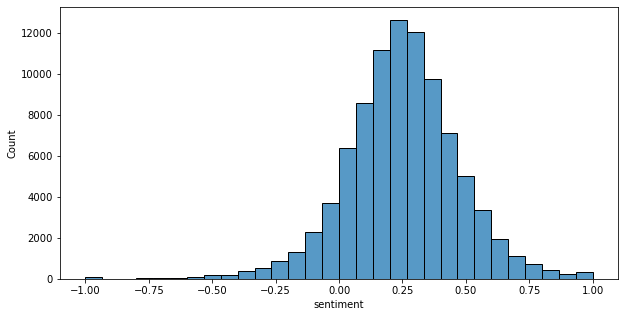

In [36]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='sentiment', palette="tab20c", bins=30);

In [37]:
print(f"Number of entries with a 0 sentiment score: {len(df[df['sentiment'] == 0])}")

Number of entries with a 0 sentiment score: 575


**Observations:**

The distributions of sentiment, similar to the `1-5` star reviews, are left skewed to the positive.  There are very few that have a `<0` polarity score.

## Positive and Negative Terms

There will be an additional analysis below; the first process will be using NLTKs Frequency Distribution (`FreqDist`) function on observations from both negative (`0`) and positive (`1`) reviews.

In [38]:
# Tokenize the words
df['text_tok'] = df['text_clean'].apply(word_tokenize)

In [39]:
df_pos = df[df['sentiment_label'] == 1]
df_neg = df[df['sentiment_label'] == 0]

In [40]:
freq_stats_pos = [item for sublist in df_pos['text_tok'] for item in sublist]

In [41]:
fdist_pos = FreqDist(freq_stats_pos)
fdist_pos.most_common(20)

[('good', 46618),
 ('place', 45781),
 ('food', 44925),
 ('great', 39996),
 ('time', 31399),
 ('like', 28211),
 ('service', 26863),
 ('get', 26674),
 ('one', 26216),
 ('really', 22467),
 ('back', 22156),
 ('go', 21760),
 ('would', 21267),
 ('also', 18258),
 ('nice', 16406),
 ('restaurant', 15640),
 ('best', 15570),
 ('got', 15404),
 ('well', 14790),
 ('love', 14734)]

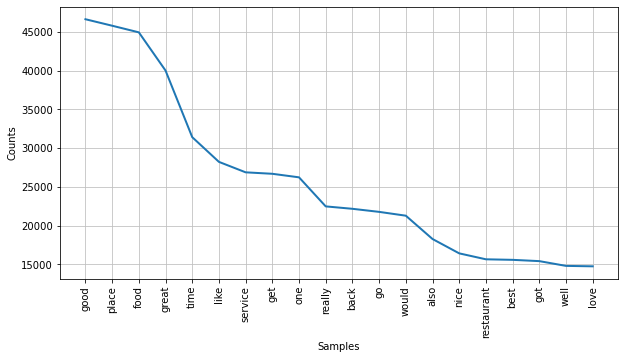

In [42]:
plt.figure(figsize=(10, 5))
fdist_pos.plot(20, cumulative=False)
plt.show()

**Observations**: Some of the top words are positive words like `good`, `place`, `food`, and `great`.  `Service` also appears frequently.  Many of the words are adjectives related to the experiences.

In [43]:
freq_stats_neg = [item for sublist in df_neg['text_tok'] for item in sublist]

In [44]:
fdist_neg = FreqDist(freq_stats_neg)
fdist_neg.most_common(20)

[('food', 5694),
 ('place', 4474),
 ('time', 4407),
 ('service', 4183),
 ('like', 3579),
 ('get', 3575),
 ('one', 3524),
 ('back', 3309),
 ('would', 3086),
 ('order', 2879),
 ('go', 2875),
 ('chicken', 2782),
 ('u', 2693),
 ('never', 2506),
 ('even', 2434),
 ('dont', 2357),
 ('got', 2273),
 ('minute', 2127),
 ('ordered', 2113),
 ('bad', 2094)]

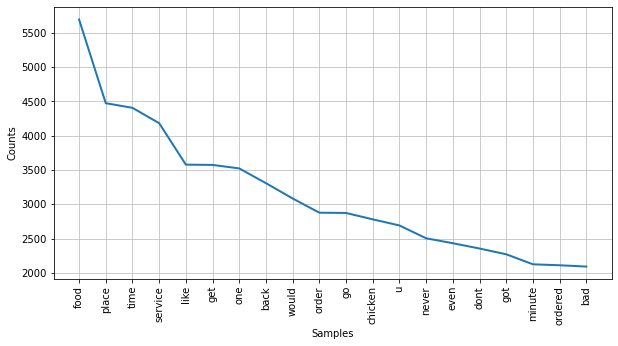

In [45]:
plt.figure(figsize=(10, 5))
fdist_neg.plot(20, cumulative=False)
plt.show()

**Observations**: The first word in the negative reviews is `food`, which also was a positive word.  That would be interesting to investigate further. To check for positive and negative uses of the word `food` in context, we can use the `concordance` feature of NLTK.

In [46]:
pos_text = nltk.Text(freq_stats_pos)
pos_text.concordance('food', lines=10)

Displaying 10 of 44925 matches:
ing comfortable spot grab beer share food friend pearl place went pm monday wa
 put buck got left poor service idea food since didnt even get order second pl
ait staff attentive everyone enjoyed food nothing special typical brewery food
food nothing special typical brewery food stopped midweek afternoon glad one n
anks elephant im usually fan airport food usually like arrive get need go howe
 seemed popular compared surrounding food area got weekly special french dip s
ty cheap compared typical restaurant food fresh probably one best place get no
obably one best place get nonairport food airport store goto airport restauran
port restaurant last four year fresh food lot allergyfriendly option really ki
 drink ranging kombucha soda alcohol food look curry ratatouille pastrami sand


In [47]:
neg_text = nltk.Text(freq_stats_neg)
neg_text.concordance('food', lines=10)

Displaying 10 of 5694 matches:
e flying elephant ever hot breakfast food mediocre best burnt dry bland took f
rdered espresso americano worse fast food joint complained weak offer remake a
ordon blue sandwich little legal sea food kiosk absolutely disgusting lettuce 
s good brand name mean airport kiosk food decent boy wrong awful eat restauran
er flight asked hostess possible get food quickly enough hostess said yes trie
ooked silverware imagining delicious food friend told u saw brown mm x mm piec
riend told u saw brown mm x mm piece food stuck knife friend flagged bus boy a
cook matter good could possibly make food fast enough u enjoy departure asked 
 leave search quicker service actual food water leaving server smiled u done g
e time first couple time even though food outstanding bit confused perhaps kit


**Observations:**

 - When looking at food in the context of the various reviews, both `positive` and `negative`, we can get an idea of the sentiment of each type.  There are clear positive and negative usages of the same words in context.

# FEATURE SELECTION/ MODELING 

determine features to be applied and create a model

In [48]:
targets = ['categories', 'city', 'state', 'postal_code', 'is_open', 'text_len', 'useful', 'cool', 'funny', 'review_count', 'sentiment']

In [49]:
catFeat = df[targets].copy()

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


catFeat['categories'] = le.fit_transform(catFeat['categories'].astype(str))
catFeat['city'] = le.fit_transform(catFeat['city'].astype(str))
catFeat['state'] = le.fit_transform(catFeat['state'].astype(str))
catFeat['postal_code'] = le.fit_transform(catFeat['postal_code'].astype(str))

catFeat.head()

,categories,city,state,postal_code,is_open,text_len,useful,cool,funny,review_count,sentiment
0,2803,24,1,385,1,630,1,0,0,86,0.442381
1,2803,24,1,385,1,885,0,0,0,86,0.006639
2,2803,24,1,385,1,174,0,0,0,86,0.666667
3,2803,24,1,385,1,553,0,0,0,86,0.389201
4,2803,24,1,385,1,841,0,0,0,86,0.391765


In [51]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(catFeat, 
                                                    df['target'], 
                                                    test_size=0.3, random_state=0)

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

clf.fit(X_train, y_train)

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, clf.feature_importances_):
    if feature[1] > .05:
        print(feature)
        total_importance += feature[1]
        
print('\n', total_importance)

('categories', 0.09638723278864184)
('postal_code', 0.08025220467141109)
('text_len', 0.13693978038559354)
('review_count', 0.09762442638604438)
('sentiment', 0.4532302991388874)

 0.8644339433705783


**Notes:**  

Based on the RandomForest test for classifier importance, `categories`, `postal_code`, `text_len`, and `review_count` (and `sentiment`) are the most important features adding up to about `0.86` of the total importance. 

## Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict the star rating (`postive` as `4-5` stars and negative `1-3` stars) based on the text from the review and the sentiment of that text, the other categories identified above.

### Model Selection

Many algorithms support binary classification.  We will use two and compare the results to select the best model.

 - **Random Forest Classifier**:  This classifier tends to be very robust.  It was used in the feature selection model above and will be tested against the features it selected.  Due to the nature of running many decision trees, it can take a while to compute larger datasets.
 > *A Random Forest classifier is an ensemble learning method for classification, regression, and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees [4].*
 - **Logistic Regression**: The logistic model is a fast and robust model that tends to run fairly quickly on all types of models.
 > *The logistic model (or logit model) is used to model the probability of a certain class or event existing, such as pass/fail, win/lose, alive/dead, or healthy/sick. This can be extended to model several classes of events, such as determining whether an image contains a cat, dog, or lion. Each object is detected in the image would be assigned a probability between 0 and 1, with a sum of one [5].*
 - **Decision Tree Classifier**: Finally, a simple Decision Tree classifier to compare that to the Random Forest.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline.

In [52]:
X = df[['categories', 'postal_code', 'text_len', 'review_count', 'text', 'sentiment']]
y = df['target']

In [53]:
print(X.shape)
print(y.shape)

(90649, 6)
(90649,)


In [62]:
def create_pipe(clf, ngrams=(1,1)):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
        [('Text', TfidfVectorizer(stop_words='english', ngram_range=ngrams), 'text'),
         ('Cats', TfidfVectorizer(), 'categories'),
         ('Categorical', OneHotEncoder(dtype='int', handle_unknown='ignore'),['postal_code']),
         ('Nums', MinMaxScaler(), ['review_count', 'text_len', 'sentiment'])],
        remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [55]:
models = {'RandForest' : RandomForestClassifier(random_state=42, n_estimators=50),
          'LogReg' : LogisticRegression(random_state=42, max_iter=1000),
          'DecisionTree' : DecisionTreeClassifier(random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    %time scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=6, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

CPU times: user 1.01 s, sys: 1.45 s, total: 2.47 s
Wall time: 13min 51s
RandForest : Mean f1 Macro: 0.811 and Standard Deviation: (0.004)
CPU times: user 1.13 s, sys: 1.82 s, total: 2.95 s
Wall time: 5min 57s
LogReg : Mean f1 Macro: 0.864 and Standard Deviation: (0.004)
CPU times: user 1.05 s, sys: 1.43 s, total: 2.48 s
Wall time: 14min 53s
DecisionTree : Mean f1 Macro: 0.746 and Standard Deviation: (0.005)


**Notes:**
 - The best performing algorithm was the `LogisticRegression` with an `f1-macro` score of `0.864`.
 - `LogisticRegression` was also the fastest performing model.
 - The single `DecisionTreeClassifier` performed the worst overall with a score of `0.746`.
 - Model performance improved from `0.722` to `0.864` for `LogisticRegression` after adding the variables `categories`, `city`, `postal_code`, `text_len`, and `review_count` to the pipeline vs. only having `text` and `sentiment`. (*not shown--data from prior run*).
 - This demonstrates the value of the Feature Importance for Feature Selection performed prior.
 
 
The final model choice for the next phase of the work will be the `LogisticRegresion` classifier for its solid performance and overall speed.

# PERFORMANCE ASSESSMENT

Now that we have a model selected based on the cross-validation above, we can optimize the `Hyper Parameters` associated with the algorithm.  This allows for optimal results, potentially over and above the default settings.  

## Hyper Parameter Tuning

> *In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.*

> *Hyperparameters can be classified as model hyperparameters, that cannot be inferred while fitting the machine to the training set because they refer to the model selection task, or algorithm hyperparameters, that in principle have no influence on the performance of the model but affect the speed and quality of the learning process. An example of a model hyperparameter is the topology and size of a neural network. Examples of algorithm hyperparameters are learning rate and mini-batch size. [9]*

In [56]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [57]:
print(y_train.shape)
print(X_train.shape)

(60734,)
(60734, 6)


In [58]:
def get_params(parameters, X, y, pipeline):
    ''' implements a the GridSearch Cross validation for a given model and set of parameters'''
    
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipeline, parameters, scoring='f1_macro', n_jobs=6, cv=cv, error_score='raise')
    grid.fit(X, y)

    return grid

In [61]:
parameters = [{'clf__solver' : ['newton-cg', 'lbfgs', 'sag', 'liblinear'],
               'clf__C' : [.1, 1, 10],
               'prep__Text__ngram_range': [(1, 1), (2, 2), (1, 2)]}]

clf = LogisticRegression(random_state=42, max_iter=500)
pipeline = create_pipe(clf)
grid = get_params(parameters, X_train, y_train, pipeline)

print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

log_C = grid.best_params_['clf__C']
log_solver = grid.best_params_['clf__solver']
log_ngram = grid.best_params_['prep__Text__ngram_range']

Best cross-validation accuracy: 0.867
Test set score: 0.874
Best parameters: {'clf__C': 10, 'clf__solver': 'liblinear', 'prep__Text__ngram_range': (1, 2)}


**Notes:**
1. **C:** Final Parameter Value = `10`
>*Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. When you train a model such as a logistic regression model, you are choosing parameters that give you the best fit to the data. This means minimizing the error between what the model predicts for your dependent variable given your data compared to what your dependent variable actually is. [6]*
1. **Solver:** Final Parameter Value = `liblinear`
>*LIBLINEAR is a simple package for solving large-scale regularized linear
classification, regression and outlier detection.*
1. **N-Grams:** Final Parameter Value = `(1,2)`
>*A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. The frequency distribution of every bigram in a string is commonly used for simple statistical analysis of text in many applications, including in computational linguistics, cryptography, and speech recognition*

## Model Evaluation

In [63]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [64]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1], normalize=False)

              precision    recall  f1-score   support

           0      0.830     0.827     0.828      9545
           1      0.919     0.920     0.920     20370

    accuracy                          0.891     29915
   macro avg      0.874     0.874     0.874     29915
weighted avg      0.891     0.891     0.891     29915

Confusion matrix, without normalization


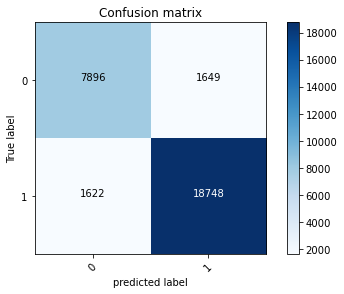

In [65]:
clf = LogisticRegression(C=log_C, solver=log_solver, random_state=42, max_iter=500)
pipeline = create_pipe(clf, log_ngram)
fit_and_print(pipeline, 'Logistic Regression')

**Observations**:

This model performed extremely well across our dataset with an `f1 macro` score of `0.874`.  The dataset has imbalanced, which was corrected for SMOTE (Over Sampling combined with Undersampling).  The result was a very strong predictor model based on `categories`, `categories`, `postal_code`, `text_len` `review_count`, and `sentiment`.

**Synthetic Minority Oversampling Technique** uses a nearest-neighbor approach for generating new minority class samples.  The method is applied only to the training data and then tested on the original, untouched test partition.  The method chosen here is first to oversample the minority class making it balanced, and then undersample it to reduce the size.  This helps bring balance without bloating the dataset.

## Multi-Label Classification Model for Category Selection

A multi-label classification model differs from a binary classification model where the target (`y`) variable has multiple options that it could result in.  In our example, the `categories` variable is a list that contains multiple options.  When a business sets these up, they can select from a list of options and any number of them.  A list looks like this.

`[Gastropubs, Food, Beer Gardens, Restaurants]`

This exercise will determine what categories the algorithm determines are appropriate based on the text from the review.

In [66]:
df['categories'] = df['categories'].apply(lambda w: re.sub(' ', '', w))
df['categories'] = df['categories'].apply(lambda w: w.split(","))

In [67]:
df['categories'][0]

['Gastropubs',
 'Food',
 'BeerGardens',
 'Restaurants',
 'Bars',
 'American(Traditional)',
 'BeerBar',
 'Nightlife',
 'Breweries']

In [68]:
X = df[['text', 'categories']]
y = df['categories']

In [69]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [70]:
print(X.shape)
print(y.shape)
print(mlb.classes_[1:20])

(90649, 2)
(90649, 971)
['Accessories' 'Accountants' 'AcneTreatment' 'ActiveLife' 'Acupuncture'
 'AddictionMedicine' 'Adult' 'AdultEducation' 'AdultEntertainment'
 'Advertising' 'Aestheticians' 'Afghan' 'African' 'AirDuctCleaning'
 'Airlines' 'AirportLounges' 'AirportShuttles' 'Airports' 'Allergists']


In [71]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = ColumnTransformer(
        [('text', TfidfVectorizer(stop_words='english'), 'text')],
        remainder='drop') 
    
    pipeline = Pipeline([('prep',column_trans), 
                         ('clf', clf)])
     
    return pipeline

### Multi-Label Model Validation

In [72]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [73]:
print(y_train.shape)
print(X_train.shape)

(60734, 971)
(60734, 2)


In [74]:
clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state=42))
pipeline = create_pipe(clf)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score = metrics.f1_score(y_test, y_pred, average='macro')

report = metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)

In [75]:
# Retreive the text lables from the MultiLabelBinarizer
pred_labels = mlb.inverse_transform(y_pred)

# Append them to the DataFrame
X_test['Predicted Categories'] = pred_labels

In [76]:
# Display a random sample of them
pd.set_option('display.max_colwidth', -1)
X_test.sample(5, random_state=60)

,text,categories,Predicted Categories
7865,"Dr. Cheng Dental office was one of the best dentist place I've been too! Keep in mind I haven't been to the dentist since I was a child. I was afraid about the doctor telling me how bad my teeth were. But the dental exams were very affordable especially for people without insurance like myself and the staff there was very kind, nice and gentle with my teeth which made my check up less frighting. The people that were working there were all polite to me especially when delivering the bad news of how many cavities I had and how much it would cost to fix each one. Overall I would recommend Dr. Cheng to anyone looking for affordable dental care. They certainly made my experience of dental work less frighting and I would highly recommend them to any friends and family looking for dental care, and another bonus is the variety of languages that the staff offers from English, Spanish, Vietnamese, etc. I look forward to my next appointment with Dr. Cheng!","[OralSurgeons, Dentists, CosmeticDentists, Health&Medical, Endodontists, PediatricDentists, GeneralDentistry]","(CosmeticDentists, DentalHygienists, Dentists, Doctors, Endodontists, Fitness&Instruction, GeneralDentistry, Health&Medical, MedicalCenters, OralSurgeons, Orthodontists, PediatricDentists, Pediatricians, Periodontists, Prosthodontists, Trainers)"
41152,"I am not really used to being pampered, getting my nails done and such, but my friend and I needed it. We went here on a whim, because we wanted to relax. The place was beautiful, the music relaxing, scenic pics on the HDTV. The ladies that work there were nice, they could not speak English, so it was hard to understand them, but they work hard, were gentle, and knew what they were doing. We chose the shellac style of getting our nails done, and it was very fair priced too.","[Beauty&Spas, HairRemoval, NailSalons]","(Beauty&Spas, DaySpas, EyelashService, HairRemoval, HairSalons, Health&Medical, Massage, NailSalons, SkinCare, Waxing)"
74199,"So, I came in with a really annoying drunk person, had 1/3rd of a beer then had to leave. The bartender was really cool about the whole thing...entertained him for 30 mins. So, I made a promise to come back at another time.\n\nAbout a month later, i came in with my growler, and really got a chance to look at the bottle selection.\n\nIf you're a fan of the Hop Wars that have been going on in PDX, you're probably going to want to visit NWIPA. They focus directly on the hoppiest beers possible...including a great selection of Imperials. A few beers on tap, and they'll fill your growler for a reasonable price.\n\nTheir menu is limited...but very eclectic...meatball sandwich, oysters, ice cream.\n\nI've since been back, and have had the sandwich...pretty delicious!","[Bars, BeerGardens, Nightlife]","(American(New), American(Traditional), Bars, Beer, BeerBar, BeerGardens, Breweries, Canadian(New), Food, Gastropubs, Italian, Nightlife, Pubs, Sandwiches, Wine&Spirits)"
93178,"This is a review for the State Auto Inspection Sticker service (I've never purchased gas here or had any work done on the car).\nThe service was excellent. As good as it could be. There's a sign where you pull up and wait, it says ""Inspection: Pull up here and wait, have your registration and $35 cash in hand, exact change"" . I waited there for about 30 seconds and a dude came up to the car and checked the lights. Then I stepped out of the car and he took it from there. 10 minutes later I was on my way. He was very friendly.","[AutoRepair, GasStations, Tires, Automotive]","(AutoDetailing, AutoParts&Supplies, AutoRepair, Automotive, BodyShops, CarDealers, CarInspectors, CarWash, GasStations, OilChangeStations, SmogCheckStations, Tires, Towing, UsedCarDealers)"
78168,Jodi is an extremely knowledgeable expert in the lending industry. She exercises great care and diligence throughout the process and is an excellent problem solver. I know when I refer her to my clients that they are w

**Observations:**
- There is no direct performance metric we can use to assess the results to use a visual inspection.
- The `Predicted Categories` column show which categories the Multi-Class Classification Model selected.  
- In the `5` sample show, there appears to be a very high match from what is predicted vs. what the business selected.
- In most cases, additional categories were listed, but they seem like logical selections in many cases.
- In the final example, it did select a `Health&Medical` category which is out of place. However, the description is short and most likely saw words like `care` as a word with a strong probability of showing up with Heath services.

## Neural Network for Review Classification

Next, we'll attempt to build a new classifier based on a Neural Network.

Neural networks are a set of algorithms modeled loosely after the human brain designed to recognize patterns. Machine Learning models are built off of a single algorithm tailored to solve a particular problem. Neural Networks are built off multiple layers that can process data through each layer, constantly refining its learnings.

Neural Networks are composed of layers that are made from nodes. Neural networks are often drawn as a graph of interconnecting nodes organized in vertical sets representing layers. The three-layer types are the input, hidden, and output layers. The input layer's size is determined by the number of dimensions in your dataset, and the output layer is the number of different classes of objects. There can be any number of hidden layers, and one typically experiments to get the best results. Each node in the network is where the computation takes place. Each of these nodes processes data that passes through it, along with various weights given to each input. As the layer computes, it's looking for which nodes perform the best, then passes through activation to the next layer.


![Neural Network](https://raw.githubusercontent.com/broepke/DATA110/main/Final%20Project/NN.png)

In [128]:
X = df['text_clean']
y = df['target']

In [129]:
print(X.shape)
print(y.shape)

(90649,)
(90649,)


In [130]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [131]:
print(y_train.shape)
print(X_train.shape)

(63454,)
(63454,)


In [132]:
X_train = X_train.to_numpy(copy=True)
y_train = y_train.to_numpy(copy=True)

In [133]:
vectorize_layer = TextVectorization(standardize='lower_and_strip_punctuation', ngrams=(1,2))
vectorize_layer.adapt(X_train)

In [134]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [135]:
first_review = X_train[0]
first_label = y_train[0]
print("Review:", first_review)
print("Label:", y_train[0])
print("Vectorized Review:", vectorize_text(first_review, first_label))

Review: run life owner either drug need sister offered watch kid send get nail done jumped chance came across place walk there owner gail yelling cell phone strike  tell pick color shell minute answer phone behind desk yell phone several minute getting back strike  isnt anyone else answer phone wanted leave really wanted get nail painted limited time stayed woman proceeded talk every problem shed ever life mostly girl worked  year said stealing client care wanted quiet hour relaxation wanted listen yelling hour would stayed home kid free wonder staff client sight left stressed went le pocket amazes people like even stay business take go somewhere else 
Label: 0
Vectorized Review: (<tf.Tensor: shape=(1, 211), dtype=int64, numpy=
array([[    469,     444,     266,     363,    5615,     114,    1166,
            519,     652,     279,    1567,       9,     486,     188,
           7765,     746,      36,     556,       3,     315,     291,
            266,   87980,    4292,    4326,     4

In [136]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1089])
print(" 9 ---> ",vectorize_layer.get_vocabulary()[9])
print(" 989047 ---> ",vectorize_layer.get_vocabulary()[989047])
print(" 789863 ---> ",vectorize_layer.get_vocabulary()[789863])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  bottom
 9 --->  get
 989047 --->  left stressed
 789863 --->  pocket amazes
Vocabulary size: 1549189


**Notes:**
- As an example of translating the vectorized value back to the vocabulary value you can see that `1287` translatest to `bottom` and `9` to `get`.
- N-Grams were also created similar to the classification model.  `989047` as `left stressed` and `789863` as `pocked amazes`.

In [137]:
X_tr, y_tr = vectorize_text(X_train, y_train)
X_te, y_te = vectorize_text(X_test, y_test)

### Create the Neural Network

In [138]:
# Get the length of the vocabulary to understand the input feature boundary.
max_features = len(vectorize_layer.get_vocabulary())
embedding_dim = 16

In [139]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          24787040  
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 24,787,057
Trainable params: 24,787,057
Non-trainable params: 0
_________________________________________________________________


**Observations:**  
- Because this model is using `n-grams`, the number of parameters (or nodes) in this model becomes quite large at `24,787,057`.
- Without the `n-grams` the size was approximatley `1.8 million`. (not shown).

In [140]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the Neural Network

In [141]:
epochs = 10
history = model.fit(x = X_tr, y = y_tr, epochs=epochs)

Epoch 1/10
1983/1983 [==============================] - 113s 57ms/step - loss: 0.6233 - binary_accuracy: 0.6781
Epoch 2/10
1983/1983 [==============================] - 112s 56ms/step - loss: 0.5742 - binary_accuracy: 0.7017
Epoch 3/10
1983/1983 [==============================] - 111s 56ms/step - loss: 0.4901 - binary_accuracy: 0.7601
Epoch 4/10
1983/1983 [==============================] - 112s 56ms/step - loss: 0.4050 - binary_accuracy: 0.8216
Epoch 5/10
1983/1983 [==============================] - 111s 56ms/step - loss: 0.3465 - binary_accuracy: 0.8613
Epoch 6/10
1983/1983 [==============================] - 111s 56ms/step - loss: 0.3013 - binary_accuracy: 0.8837
Epoch 7/10
1983/1983 [==============================] - 112s 56ms/step - loss: 0.2746 - binary_accuracy: 0.8935
Epoch 8/10
1983/1983 [==============================] - 115s 58ms/step - loss: 0.2466 - binary_accuracy: 0.9043
Epoch 9/10
1983/1983 [==============================] - 112s 56ms/step - loss: 0.2274 - binary_accuracy:

In [142]:
loss, accuracy = model.evaluate(x = X_te, y = y_te)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

850/850 [==============================] - 0s 446us/step - loss: 0.2806 - binary_accuracy: 0.8939 0s - loss: 0.2813 - binary_accuracy: 0.89
Loss:  0.2806178033351898
Accuracy:  0.8938775658607483


In [143]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy'])

There are two entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [144]:
acc = history_dict['binary_accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)

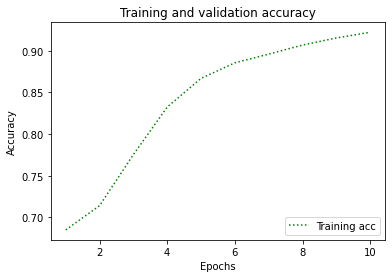

In [145]:
plt.plot(epochs, acc, 'g:', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

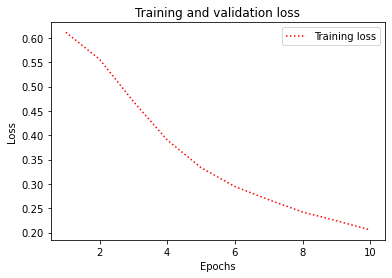

In [146]:
plt.plot(epochs, loss, 'r:', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [147]:
examples = [
  "The food was great!",
  "The service was okay.",
  "The nail salon was terrible...",
  "The food was good, the service was terrible, the decor was spectacular.",
  "Wow this thing is amazing!"
  ]

vector_examples = vectorize_layer(examples)

res = model.predict(vector_examples)

res

array([[ 19.686878],
       [-27.444866],
       [-26.02116 ],
       [-40.559227],
       [ 47.36354 ]], dtype=float32)

**Observations:**
- The values above indicate a `positive value as a positive sentiment and `negative` as a negative sentiment.
- Upon inspection, we can see that the model correctly classified each sentence.  
- The second to last sentence has a mix of positive and negative sentiment.  It was ultimately classified as negative.
- For the last sentence, which has the most positive feeling, we can see that this also has the highest value.

# CONCLUSION 

After running and optimizing the analysis for the questions we set out, let's look at the conclusions drawn from each.

**Lexicon Based Sentiment**  
We leveraged the lexicon model for sentiment analysis, specifically for word frequencies across positive and negative reviews.  Here we found common words in the positive reviews such as  `good`, `place`, `food`, and `great`.  `service` also appears frequently. When we looked at negative reviews, the word `food` appeared near the top of the list. Restaurants were popular categories in the dataset, and words that corresponded to them dominated positive and negative frequencies.

**Machine Learning Model for Classification**  
This model proved to be quite effective. Using the `LogisticRegression` model tuned to the dataset, we achieved a `0.864` `f1-macro` score on the test set.  This means that `86.4%` of the items were correctly classified based on their sentiment.  To improve the score, we added additional information beyond the review text.  The fields added were `categories`, `city`, `postal_code`, `text_len`, and `review_count` and `sentiment`.  This improved the model by about `12%`.  It appears that the sentiment's relationship to a user's review is closely correlated.

**Multi-Label Classification**  
An interesting result came from this exercise.  We recommend that a feature be added to yelp based on this model that would recommend potential categories for business owners.  We found that in nearly all recommendations, more categories were recommended by the system than the business typically used.  We would suggest implementing a `predictive category reccomendation system` based on any reviews for the business. 

**Neural Network**  
The Neural Network also produced interesting results.  With very little tuning and only utilizing the text field, the algorithm optimized itself to a higher level of accuracy than the statistical models prior.  The final performance after the `30` epochs was `0.90` with a loss of 


# REFERENCES

1. [The Yelp Factor: Are Consumer Reviews Good for Business?](https://hbswk.hbs.edu/item/the-yelp-factor-are-consumer-reviews-good-for-business)
1. [Hyperparameter (machine learning)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))
1. [Basic Text Classification with TensorFlow](https://www.tensorflow.org/tutorials/keras/text_classification)
1. [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest)
1. [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
1. [What is the inverse of regularization strength in Logistic Regression? How should it affect my code?](https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul)
1. [LIBLINEAR -- A Library for Large Linear Classification](https://www.csie.ntu.edu.tw/~cjlin/liblinear/)
1. [Yelp on Wikipedia](https://en.wikipedia.org/wiki/Yelp)
1. [Hyperparameter Optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

**Dataset**  
1. [Yelp Reviews Dataset](https://www.yelp.com/dataset)